In [1]:
%load_ext autoreload
%autoreload 2
import sys 
from FR3Py.robot.interface import FR3Real
robot = FR3Real(robot_id='fr3')

Interface Running...


In [2]:
robot.getJointStates()

{'q': array([ 5.75722992e-04, -7.84757684e-01,  2.38246419e-03, -2.37489155e+00,
         5.17812462e-04,  1.56910584e+00,  7.85118321e-01]),
 'dq': array([-0.00103004,  0.00090316,  0.00013396,  0.00101228,  0.00041935,
        -0.00042181,  0.00028424]),
 'T': array([-0.03641057, -4.19488668, -0.79939878, 23.02035904,  0.73808515,
         2.2942884 ,  0.08745793])}

In [12]:
import time
import numpy as np

q_rest_list = []
dq_rest_list = []
for i in range(200):
    q_rest_list.append(robot.getJointStates()['q'])
    dq_rest_list.append(robot.getJointStates()['dq'])
    time.sleep(0.01)


In [14]:
# write a code that calculates the variance of a vector

q_rest_list = np.array(q_rest_list)
dq_rest_list = np.array(dq_rest_list)

for i in range(7):
    print(np.var(q_rest_list[:,i]))

for i in range(7):
    print(np.var(dq_rest_list[:,i]))



4.4422177980914225e-12
3.0589166499837683e-12
3.986482009716218e-12
4.161254389434094e-12
3.37991009741878e-12
2.131139067086004e-12
7.412394279126995e-12
7.06748093323844e-07
5.165733245878798e-07
6.500482908354889e-07
7.826609574819962e-07
7.968800881569629e-07
5.088159988121713e-07
1.3951787796684977e-06


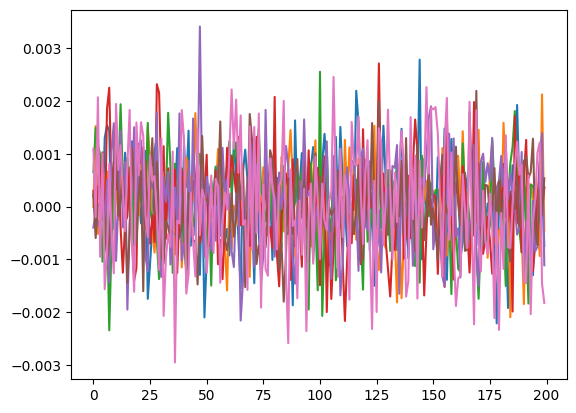

In [15]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(dq_rest_list)

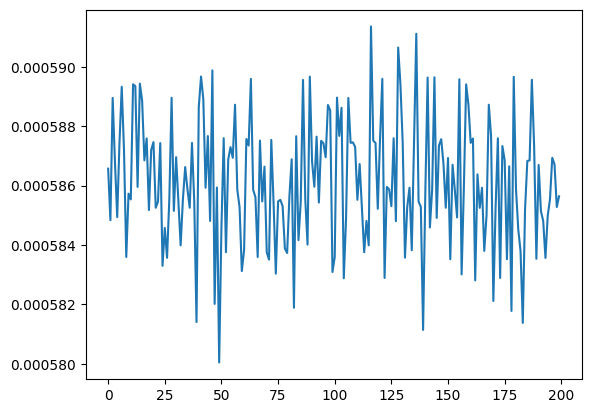

In [16]:
plt.figure(0)
q_rest_list = np.array(q_rest_list)
plt.plot(q_rest_list[:,0])

### Preparation

In [113]:
import numpy as np
from FR3Py.robot.model_collision_avoidance import PinocchioModel
import time

pin_robot = PinocchioModel()
joint_lb = np.array([-2.3093, -1.5133, -2.4937, -2.7478, -2.48, 0.8521, -2.6895])
joint_ub = np.array([2.3093, 1.5133, 2.4937, -0.4461, 2.48, 4.2094, 2.6895])
torque_lb = np.array([-87, -87, -87, -87, -12, -12, -12])
torque_ub = np.array([87, 87, 87, 87, 12, 12, 12])
joint_acc_lb = np.array([-10, -10, -10, -10, -10, -10, -10])
joint_acc_ub = np.array([10, 10, 10, 10, 10, 10, 10])
v_EE_lb = np.array([-0.05, -0.05, -0.05])
v_EE_ub = np.array([0.05, 0.05, 0.05])

n_joints = 7
q_bar = 0.5*(joint_ub + joint_lb)


In [114]:
from cores.utils.bounding_shape_coef_mj import BoundingShapeCoef
from cores.obstacle_collections.polytope_collection import PolytopeCollection
import scalingFunctionsHelperPy as sfh
import HOCBFHelperPy as hh
from scipy.spatial.transform import Rotation
import multiprocessing
from cores.utils.trajectory_utils import PositionTrapezoidalTrajectory, OrientationTrapezoidalTrajectory
from liegroups import SO3
from cores.utils.proxsuite_utils import init_proxsuite_qp
from cores.utils.rotation_utils import get_quat_from_rot_matrix
from cores.utils.kalman_filter import KalmanFilter

In [145]:
R_kf = np.diag([4e-12, 3e-12, 4e-12, 4e-12, 3e-12, 2e-12, 7e-12, 7e-7, 5e-7, 7e-7, 8e-7, 8e-7, 5e-7, 14e-7])
Q_kf = np.diag([1e-13, 1e-13, 1e-13, 1e-13, 1e-13, 1e-13, 1e-13, 8e-8, 8e-8, 8e-8, 8e-8, 8e-8, 8e-8, 8e-8])
P0_kf = R_kf.copy()
info = robot.getJointStates()
x0_kf = np.array(info["q"][:7].tolist() + info["dq"][:7].tolist())
dt = 0.005
kalman_filter = KalmanFilter(dt, Q_kf, R_kf, x0_kf, P0_kf)
ddq = np.zeros(7)

In [170]:
n_in = 3
n_controls = 7
vel_qp = init_proxsuite_qp(n_v=n_controls, n_eq = 0, n_in=n_in)

In [175]:
# Rotate link 1 to reach preparation configuration
T = 10
dt = 0.005
q_d = np.array([np.pi/3, -np.pi/4, 0, -np.pi/4*3, 0, np.pi/2, np.pi/4])
Kp_joint = np.diag([1, 1, 1, 1, 1, 1, 1])*1e2
Kd_joint = np.diag([2, 2, 2, 2, 2, 2, 2])*1e2

time_loop_list = []
q_list = []
dq_list = []
ddq_list = []
tau_list = []
q_est_list = []
dq_est_list = []
q_moving_avg_list = []
dq_moving_avg_list = []
q_moving_avg_prev = info["q"][:7] 
dq_moving_avg_prev = np.zeros(7)

weight_q_moving_avg = 0.1
weight_dq_moving_avg = 0.1

t_start = time.time()
while time.time() - t_start < T:
    time_loop_start = time.time()
    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)

    q_moving_avg = (1-weight_q_moving_avg)*q_moving_avg_prev + weight_q_moving_avg*q
    q_moving_avg_prev = q_moving_avg

    dq_moving_avg = (1-weight_dq_moving_avg)*dq_moving_avg_prev + weight_dq_moving_avg*dq
    dq_moving_avg_prev = dq_moving_avg

    q_pin = 0.025*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q_moving_avg # shape (9,)
    dq_pin[0:n_joints] = dq_moving_avg_prev # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    M = pin_info["M"][0:n_joints,0:n_joints] + 0.1*np.eye(n_joints) # shape (7,7)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq_moving_avg # shape (6,)

    W = np.diag(1.0/(joint_ub-joint_lb))
    eq = W @ (q_moving_avg - q_d)
    deq = W @ dq_moving_avg
    ddq_nominal = - Kd_joint @ deq - Kp_joint @ eq

    C = np.zeros((n_in, n_controls))
    lb = np.zeros(n_in)
    ub = np.zeros(n_in)

    h_v_lb = v_EE[0:3] - v_EE_lb
    h_v_ub = v_EE_ub - v_EE[0:3]
    C[0:3, :] = J_EE[0:3,:]
    lb[0:3] = -10*h_v_lb - dJdq_EE[0:3]
    ub[0:3] = 10*h_v_ub - dJdq_EE[0:3]

    g = -ddq_nominal

    vel_qp.update(g=g, C=C, l=lb, u=ub)
    vel_qp.solve()
    ddq = vel_qp.results.x

    # ddq = ddq_nominal

    tau = M @ ddq + nle - G

    tau = np.clip(tau, torque_lb, torque_ub)
    robot.setCommands(tau)

    time_loop_end = time.time()

    time_loop_list.append(time_loop_end - time_loop_start)
    q_list.append(q)
    dq_list.append(dq)
    ddq_list.append(ddq)
    tau_list.append(tau)
    q_moving_avg_list.append(q_moving_avg)
    dq_moving_avg_list.append(dq_moving_avg)

robot.setCommands(np.zeros_like(tau))


In [112]:
# Rotate link 1 to reach preparation configuration
T = 10
dt = 0.005
q_d = np.array([np.pi/3, -np.pi/4, 0, -np.pi/4*3, 0, np.pi/2, np.pi/4])
# q_d = info["q"][:7] + np.array([0.0, 0.5, 0, 0, 0, 0, 0])
# Kp_joint = np.diag([1, 1, 1, 1, 1, 1, 1])*1e2
# Kd_joint = np.diag([2, 2, 2, 2, 2, 2, 2])*1e2

# time_loop_list = []
# q_list = []
# dq_list = []
# ddq_list = []
# tau_list = []
# q_est_list = []
# dq_est_list = []

# t_start = time.time()
# while time.time() - t_start < T:
#     time_loop_start = time.time()
#     robot_info = robot.getJointStates()
#     q = robot_info['q'] # shape (7,)
#     dq = robot_info['dq'] # shape (7,)

#     kalman_filter.predict(ddq)
#     kalman_filter.update(np.concatenate([q, dq]))
#     q_est = kalman_filter.estimate()[:7]
#     dq_est = kalman_filter.estimate()[7:]

#     q_pin = 0.025*np.ones(9)
#     dq_pin = np.zeros(9)
#     q_pin[0:n_joints] = q_est # shape (9,)
#     dq_pin[0:n_joints] = dq_est # shape (9,)

#     pin_info = pin_robot.getInfo(q_pin, dq_pin)
#     P_EE = pin_info["P_EE"]
#     R_EE = pin_info["R_EE"]
#     M = pin_info["M"][0:n_joints,0:n_joints] + 0.1*np.eye(n_joints) # shape (7,7)
#     nle = pin_info["nle"][0:n_joints]  # shape (7,)
#     G = pin_info["G"][0:n_joints]  # shape (7,)

#     W = np.diag(1.0/(joint_ub-joint_lb))
#     eq = W @ (q_est - q_d)
#     deq = W @ dq_est
#     ddq_nominal = - Kd_joint @ deq - Kp_joint @ eq

#     J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
#     dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
#     v_EE = J_EE @ dq_est # shape (6,)

#     C = np.zeros((n_in, n_controls))
#     lb = np.zeros(n_in)
#     ub = np.zeros(n_in)

#     C[:,:] = J_EE[0:3,:]*dt
#     lb[:] = v_EE_lb[:3] - v_EE[:3] - dJdq_EE[:3]*dt
#     ub[:] = v_EE_ub[:3] - v_EE[:3] - dJdq_EE[:3]*dt
#     g = -ddq_nominal

#     vel_qp.update(g=g, C=C, l=lb, u=ub)
#     vel_qp.solve()
#     ddq = vel_qp.results.x

#     # ddq = ddq_nominal

#     tau = M @ ddq + nle - G

#     tau = np.clip(tau, torque_lb, torque_ub)
#     robot.setCommands(tau)

#     time_loop_end = time.time()

#     time_loop_list.append(time_loop_end - time_loop_start)
#     q_list.append(q)
#     dq_list.append(dq)
#     ddq_list.append(ddq)
#     tau_list.append(tau)
#     q_est_list.append(q_est)
#     dq_est_list.append(dq_est)

# robot.setCommands(np.zeros_like(tau))

In [165]:
# Rotate link 1 to reach preparation configuration
# T = 10
# dt = 0.005
# q_d = np.array([np.pi/3, -np.pi/4, 0, -np.pi/4*3, 0, np.pi/2, np.pi/4])
# # q_d = info["q"][:7] + np.array([0.0, 0.5, 0, 0, 0, 0, 0])
# Kp_joint = np.diag([1, 1, 1, 1, 1, 1, 1])*1e2
# Kd_joint = np.diag([2, 2, 2, 2, 2, 2, 2])*1e2

# time_loop_list = []
# q_list = []
# dq_list = []
# ddq_list = []
# tau_list = []
# q_est_list = []
# dq_est_list = []
# q_moving_avg_list = []
# dq_moving_avg_list = []
# q_moving_avg_prev = info["q"][:7] 
# dq_moving_avg_prev = np.zeros(7)

# weight_q_moving_avg = 0.05
# weight_dq_moving_avg = 0.05

# t_start = time.time()
# while time.time() - t_start < T:
#     time_loop_start = time.time()
#     robot_info = robot.getJointStates()
#     q = robot_info['q'] # shape (7,)
#     dq = robot_info['dq'] # shape (7,)

#     q_moving_avg = (1-weight_q_moving_avg)*q_moving_avg_prev + weight_q_moving_avg*q
#     q_moving_avg_prev = q_moving_avg

#     dq_moving_avg = (1-weight_dq_moving_avg)*dq_moving_avg_prev + weight_dq_moving_avg*dq
#     dq_moving_avg_prev = dq_moving_avg

#     q_pin = 0.025*np.ones(9)
#     dq_pin = np.zeros(9)
#     q_pin[0:n_joints] = q_moving_avg # shape (9,)
#     dq_pin[0:n_joints] = dq_moving_avg_prev # shape (9,)

#     pin_info = pin_robot.getInfo(q_pin, dq_pin)
#     P_EE = pin_info["P_EE"]
#     R_EE = pin_info["R_EE"]
#     M = pin_info["M"][0:n_joints,0:n_joints] + 0.1*np.eye(n_joints) # shape (7,7)
#     nle = pin_info["nle"][0:n_joints]  # shape (7,)
#     G = pin_info["G"][0:n_joints]  # shape (7,)
#     J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
#     dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
#     v_EE = J_EE @ dq_moving_avg # shape (6,)

#     W = np.diag(1.0/(joint_ub-joint_lb))
#     eq = W @ (q_moving_avg - q_d)
#     deq = W @ dq_moving_avg
#     ddq_nominal = - Kd_joint @ deq - Kp_joint @ eq

#     C = np.zeros((n_in, n_controls))
#     lb = np.zeros(n_in)
#     ub = np.zeros(n_in)

#     C[:,:] = J_EE[0:3,:]*dt
#     lb[:] = v_EE_lb[:3] - v_EE[:3] - dJdq_EE[:3]*dt
#     ub[:] = v_EE_ub[:3] - v_EE[:3] - dJdq_EE[:3]*dt
#     g = -ddq_nominal

#     vel_qp.update(g=g, C=C, l=lb, u=ub)
#     vel_qp.solve()
#     ddq = vel_qp.results.x

#     # ddq = ddq_nominal

#     tau = M @ ddq + nle - G

#     tau = np.clip(tau, torque_lb, torque_ub)
#     robot.setCommands(tau)

#     time_loop_end = time.time()

#     time_loop_list.append(time_loop_end - time_loop_start)
#     q_list.append(q)
#     dq_list.append(dq)
#     ddq_list.append(ddq)
#     tau_list.append(tau)
#     q_moving_avg_list.append(q_moving_avg)
#     dq_moving_avg_list.append(dq_moving_avg)

# robot.setCommands(np.zeros_like(tau))


In [158]:
import matplotlib.pyplot as plt

q_list = np.array(q_list)
dq_list = np.array(dq_list)
ddq_list = np.array(ddq_list)
tau_list = np.array(tau_list)
q_est_list = np.array(q_est_list)
dq_est_list = np.array(dq_est_list)
time_loop_list = np.array(time_loop_list)
q_moving_avg_list = np.array(q_moving_avg_list)
dq_moving_avg_list = np.array(dq_moving_avg_list)


In [159]:
np.mean(time_loop_list)

0.0006065395798151283

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

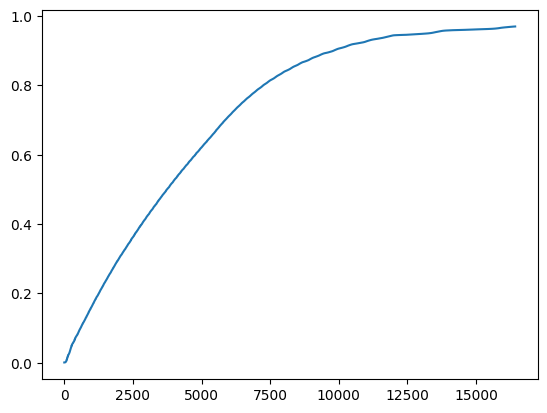

In [160]:
# create 3 by 3 subplots, and plot the q and q_est
for i in range(7):
    plt.figure(i)
    plt.plot(q_list[:,i], label='q_{:d}'.format(i))
    plt.plot(q_est_list[:,i], label='q_est_{:d}'.format(i))
    plt.legend()

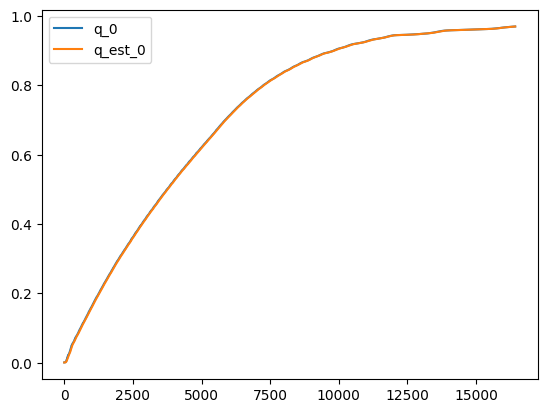

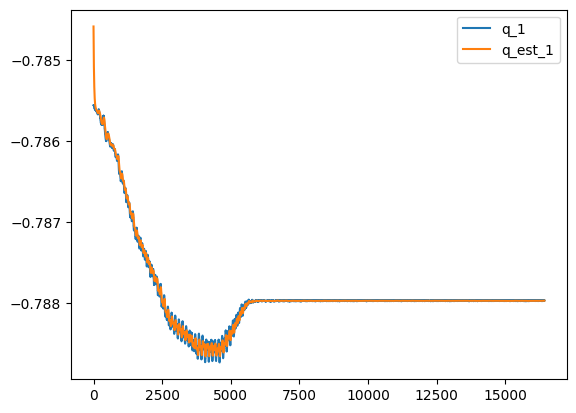

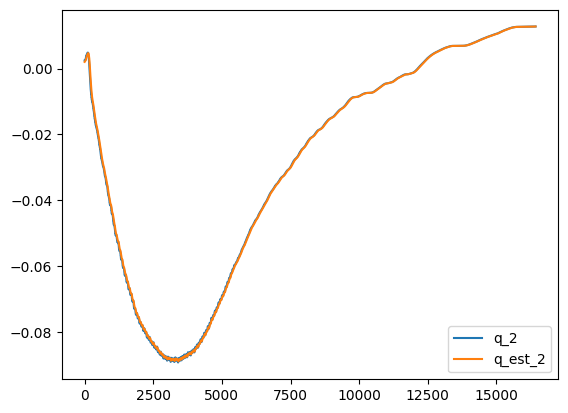

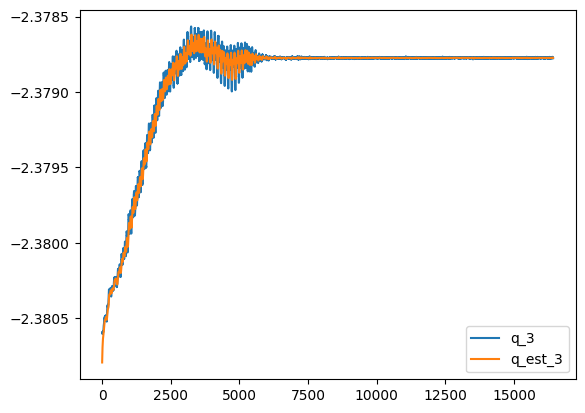

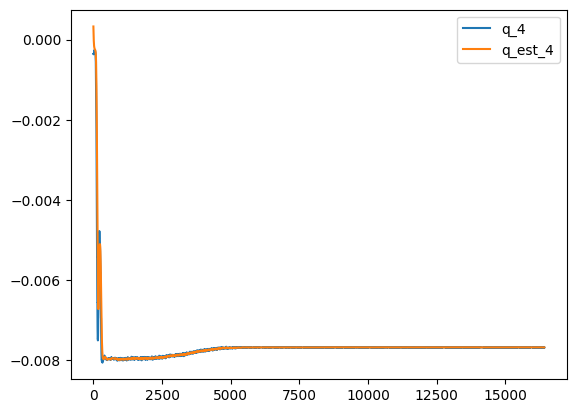

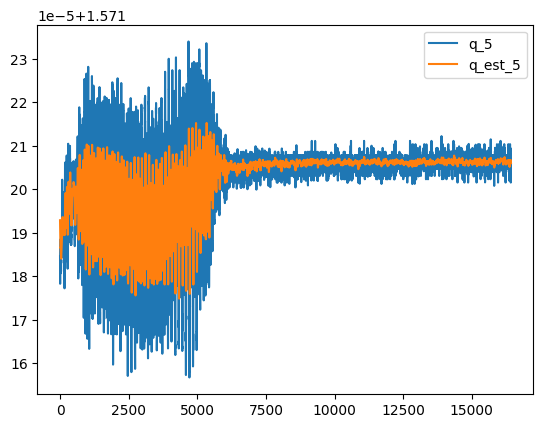

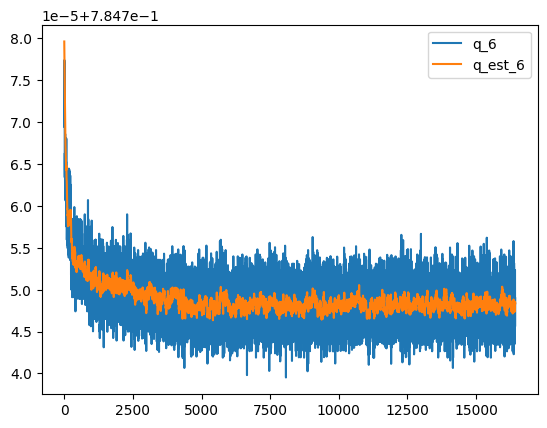

In [161]:
for i in range(7):
    plt.figure(i)
    plt.plot(q_list[:,i], label='q_{:d}'.format(i))
    plt.plot(q_moving_avg_list[:,i], label='q_est_{:d}'.format(i))
    plt.legend()

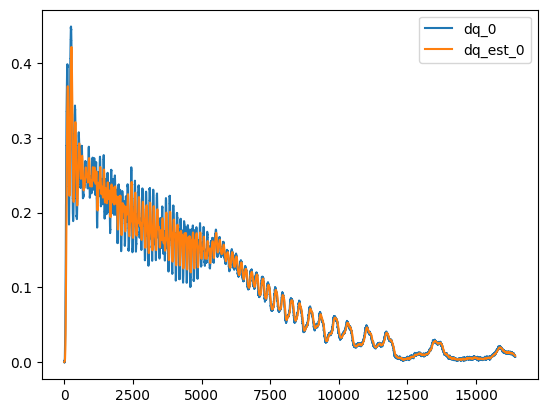

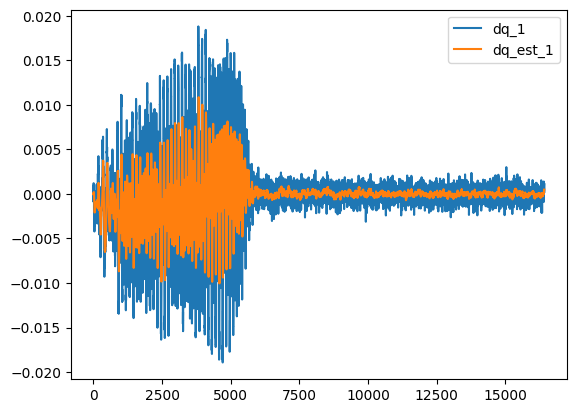

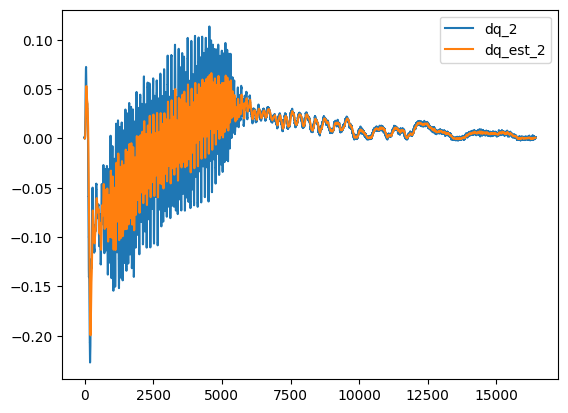

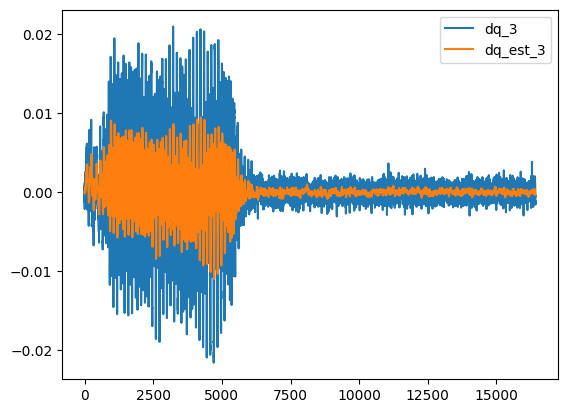

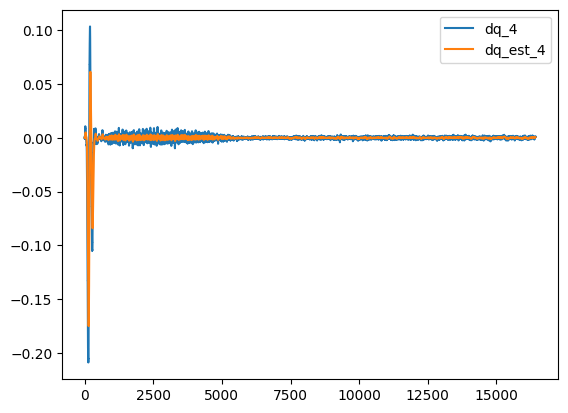

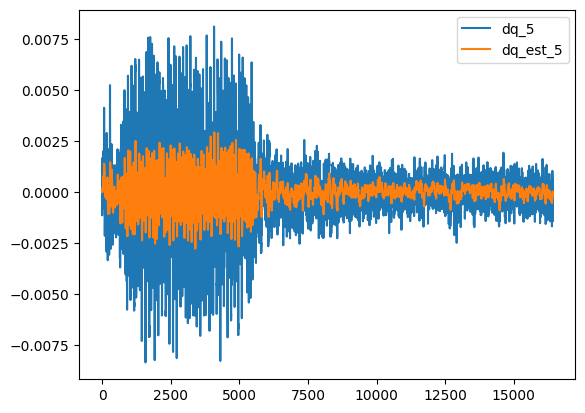

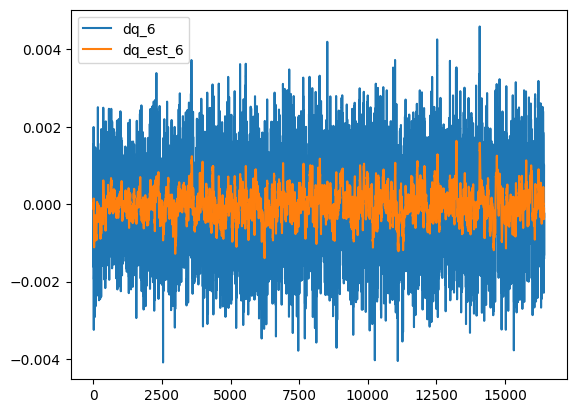

In [162]:
for i in range(7):
    plt.figure(i)
    plt.plot(dq_list[:,i], label='dq_{:d}'.format(i))
    plt.plot(dq_moving_avg_list[:,i], label='dq_est_{:d}'.format(i))
    plt.legend()

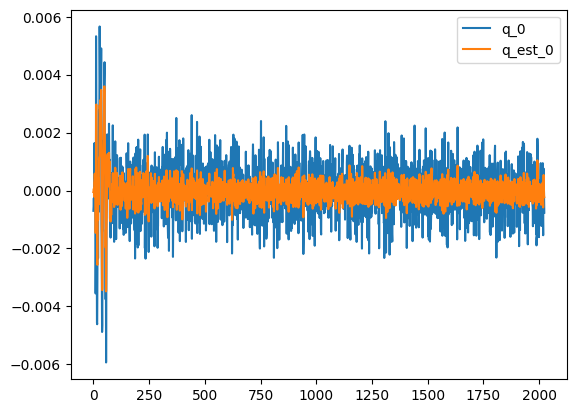

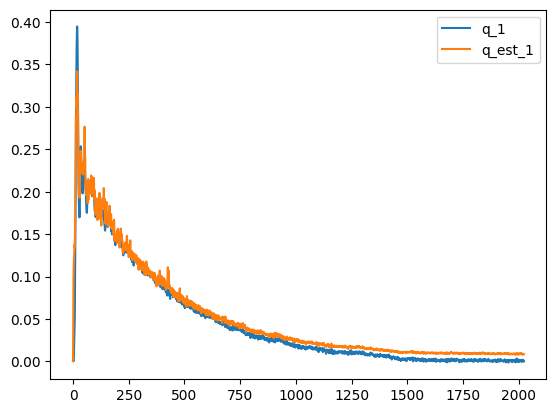

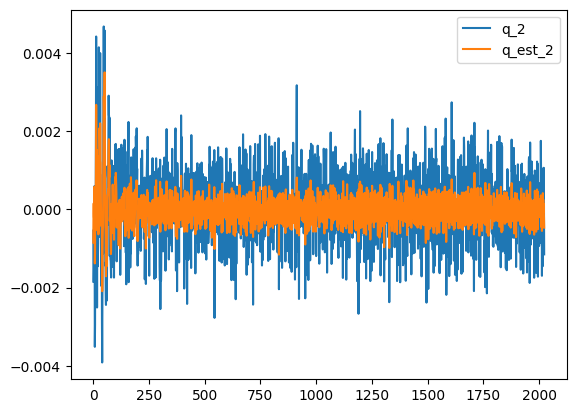

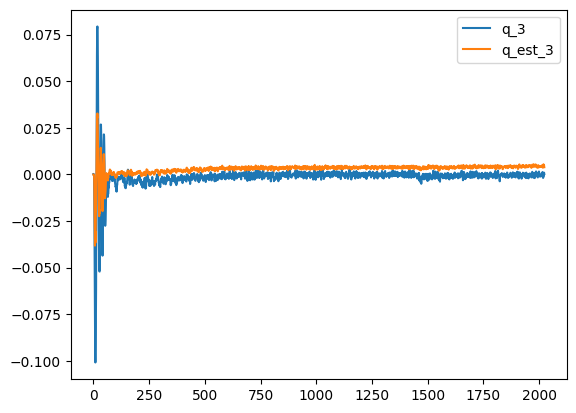

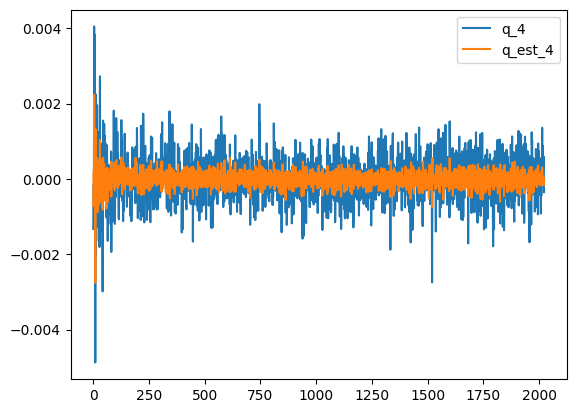

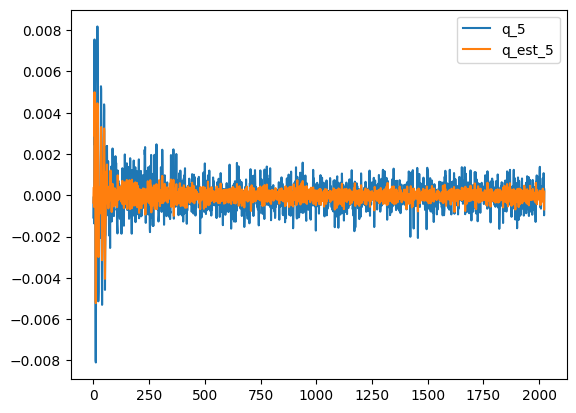

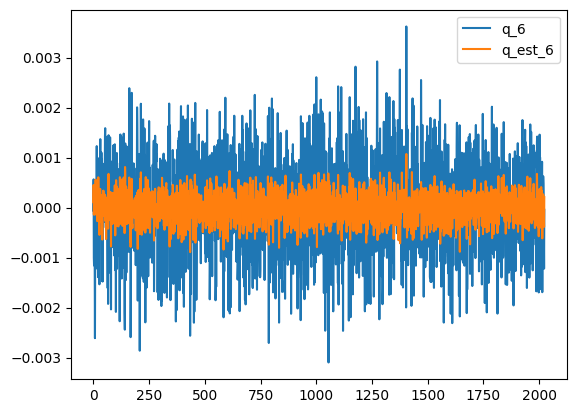

In [108]:
for i in range(7):
    plt.figure(i)
    plt.plot(dq_list[:,i], label='q_{:d}'.format(i))
    plt.plot(dq_est_list[:,i], label='q_est_{:d}'.format(i))
    plt.legend()

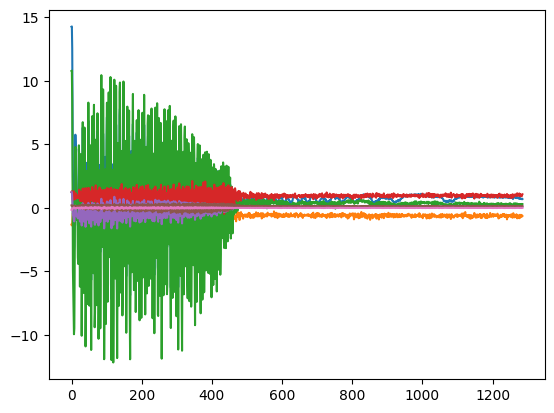

In [11]:
plt.figure()
plt.plot(tau_list)

### Generate the trajectory

In [16]:

robot_info = robot.getJointStates()
q = robot_info['q'] # shape (7,)
dq = robot_info['dq'] # shape (7,)

q_pin = 0.025*np.ones(9)
dq_pin = np.zeros(9)
q_pin[0:n_joints] = q # shape (9,)
dq_pin[0:n_joints] = dq # shape (9,)

pin_info = pin_robot.getInfo(q_pin, dq_pin)
P_EE = pin_info["P_EE"]
R_EE = pin_info["R_EE"]

t_1 = 10
t_2 = 15
t_3 = 25
t_final = 35

# Translational trajectory
P_EE_0 = P_EE.copy()
# P_EE_1 = np.array([0.16, 0.62, 0.04])
P_EE_1 = np.array([0.18, 0.61, 0.10])
# P_EE_2 = np.array([0.45, 0.25, 0.01])
P_EE_2 = np.array([0.50, 0.25, 0.08])

via_points = np.array([P_EE_0, P_EE_1, P_EE_1, P_EE_2, P_EE_2])
# via_points = np.array([P_EE_0, P_EE_0, P_EE_0, P_EE_0])

target_time = np.array([0, t_1, t_2, t_3, t_final])
Ts = 0.01
traj_position = PositionTrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=Ts)

# Rotational trajectory
R_EE_0  = R_EE.copy()

roll = np.pi
pitch = 0
yaw = np.pi/3
R_EE_1 = Rotation.from_euler('xyz', [roll, pitch, yaw]).as_matrix()

roll = np.pi
pitch = 0
yaw = np.pi/6
R_EE_2 = Rotation.from_euler('xyz', [roll, pitch, yaw]).as_matrix()

orientations = np.array([R_EE_0, R_EE_1, R_EE_1, R_EE_2, R_EE_2])
# orientations = np.array([R_EE_0, R_EE_0, R_EE_0, R_EE_0])
target_time = np.array([0, t_1, t_2, t_3, t_final])
traj_orientation = OrientationTrapezoidalTrajectory(orientations, target_time, Ts=Ts)